## Download the dataset

https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria

In [69]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [70]:
ds_url = 'https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria'

In [71]:
od.download(ds_url)

Skipping, found downloaded files in "./cell-images-for-detecting-malaria" (use force=True to force download)


In [72]:
data_dir = './cell-images-for-detecting-malaria/cell_images'

In [73]:
import os
os.listdir(data_dir)

['Parasitized', 'Uninfected']

In [74]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

Parasitized : 13780
Uninfected : 13780


In [75]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

Parasitized : 13780
Uninfected : 13780


In [95]:
# import shutil
# shutil.rmtree('./sample_data')
# shutil.rmtree('./cell-images-for-detecting-malaria/cell_images/cell_images')

In [81]:
from torchvision.datasets import ImageFolder

In [96]:
ds = ImageFolder(data_dir)

In [83]:
len(ds)

27558

In [84]:
ds[0]

(<PIL.Image.Image image mode=RGB size=142x148 at 0x7FF7CE2A1BB0>, 0)

In [85]:
ds.classes

['Parasitized', 'Uninfected']

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

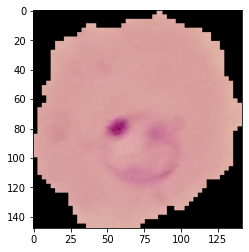

In [87]:
img, label = ds[0]
plt.imshow(img)

In [134]:
import torchvision.transforms as tt
train_ds = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                             tt.RandomCrop(64),
                                             tt.ToTensor()]))

In [89]:
val_pct = 0.2                     # Validation Percentage
val_size = int(val_pct * len(train_ds)) # Validation Size
train_size = len(train_ds) - val_size
train_size, val_size

(22047, 5511)

In [90]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train_ds, [train_size, val_size])
len(train_ds), len(val_ds)

(22047, 5511)

In [91]:
len(train_ds), len(val_ds)

(22047, 5511)

In [118]:
batch_size = 128

from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

val_dl = DataLoader(val_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

In [119]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

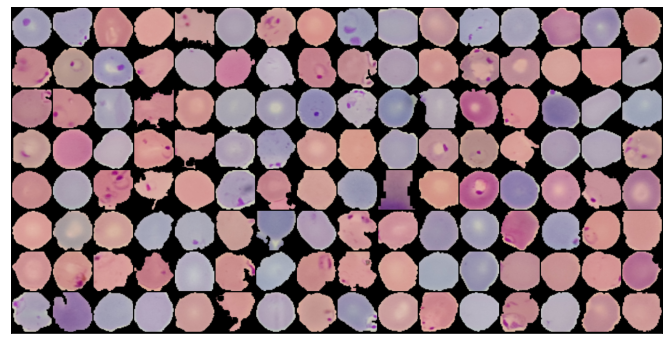

In [120]:
show_batch(train_dl) # will show a batch of the training dataloader

## GPU Utilities

In [121]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [122]:
torch.cuda.is_available()

True

In [123]:
device = get_default_device()
device

device(type='cuda')

In [124]:
img, label = train_ds[0]
img.device

device(type='cpu')

In [125]:
# Bydefault its on CPU so we have to change it
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [126]:
# Wrapping the training dataloader with the device
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Model & Training Utilities

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):    
      # Calculate Loss for a batch of Training data
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):       
      # Calculate Loss & Accuracy for a batch of Validation data
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
  # Evaluates the model's Performance on the Validation dataset
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input : 128 x 3 x 64 x 64
        
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3,len(ds.classes)), device)
model

In [ ]:
model.conv1[0].weight.device

In [ ]:
for batch in train_dl:
  images, labels = batch
  print('images.shape', images.shape)
  print('images.device', images.device)
  preds = model(images)
  print('preds.shape', preds.shape)
  break

In [ ]:
history = [evaluate(model, val_dl)]
history

In [ ]:
history += fit(5, 0.001, model, train_dl, val_dl, torch.optim.Adam)

In [ ]:
history += fit(3, 0.0001, model, train_dl, val_dl, torch.optim.Adam)

In [ ]:
history += fit(3, 0.0001, model, train_dl, val_dl)

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

In [ ]:
!pip install jovian --upgrade --quiet
import jovian

In [ ]:
jovian.reset()
jovian.log_dataset(image_size=64,
                   arch='ResNet9',
                   epoch=[5,5,5],
                   lrs=[0.001, 0.0001, 0.0001],
                   opt=['Adam', 'Adam', 'SGD'])
jovian.log_metrics(train_loss=history[-1]['train_loss'],
                   val_loss=history[-1]['val_loss'],
                   val_acc=history[-1]['val_acc'])

In [ ]:
jovian.commit(project='deep-learning-project-malaria-detector')

## Testing with Individual Images

In [ ]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

def predictions(num):
  img, label = val_ds[num]
  plt.imshow(img.permute(1,2,0))
  pred = predict_image(img, model, ds.classes)
  print('Target :', ds.classes[label])
  print('Prediction :', pred)

In [ ]:
predictions(7)

In [ ]:
predictions(9)

In [ ]:
predictions(10)

In [ ]:
predictions(15)

In [ ]:
predictions(0)

In [ ]:
predictions(1)

In [ ]:
predictions(2)

## Transfer Learning

In [ ]:
from torchvision import models

class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = to_device(ResNet34(len(ds.classes), pretrained=True), device)

In [ ]:
import torchvision.transforms as T

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_ds = ImageFolder(data_dir, tt.Compose([tt.Resize(img_size),
                                      tt.RandomCrop(img_size),
                                      tt.ToTensor(),
                                      tt.Normalize(*imagenet_stats)]))

In [ ]:
val_pct = 0.2                     # Validation Percentage
val_size = int(val_pct * len(train_ds)) # Validation Size
train_size = len(train_ds) - val_size
train_size, val_size

In [ ]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train_ds, [train_size, val_size])
len(train_ds), len(val_ds)

In [ ]:
batch_size = 64

len(train_ds), len(val_ds)

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

val_dl = DataLoader(val_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [62]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.0014493465423584, 'val_acc': 0.5174979567527771}]

In [63]:
history += fit_one_cycle(5, 0.001, model, train_dl, val_dl,
               weight_decay=0.01, grad_clip=0.1, opt_func=torch.optim.Adam)

  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.1806, val_loss: 0.2680, val_acc: 0.9008


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.2063, val_loss: 0.2383, val_acc: 0.9411


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.1840, val_loss: 0.1733, val_acc: 0.9431


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.1613, val_loss: 0.1431, val_acc: 0.9503


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.1368, val_loss: 0.1238, val_acc: 0.9574


In [64]:
history += fit_one_cycle(3, 0.0001, model, train_dl, val_dl,
               weight_decay=0.01, grad_clip=0.1, opt_func=torch.optim.Adam)

  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.1321, val_loss: 0.1454, val_acc: 0.9506


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.1314, val_loss: 0.1329, val_acc: 0.9524


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.1186, val_loss: 0.1188, val_acc: 0.9589


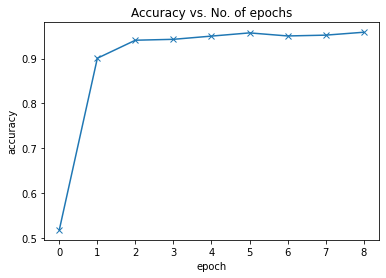

In [65]:
plot_accuracies(history)

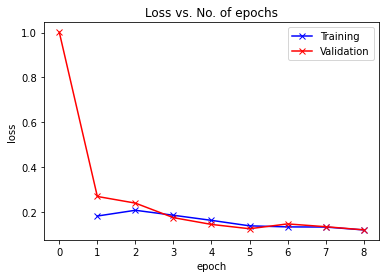

In [66]:
plot_losses(history)

In [132]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', train_ds.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

def predictions_2(num):
  img, label= val_ds[num]
  show_image(img, label)
  pred = predict_image(img, model, train_ds.classes)
  print('Prediction :', pred)

Label: Uninfected (1)
Prediction : Uninfected


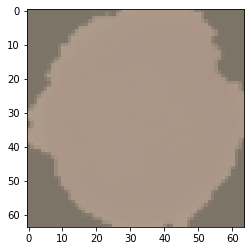

In [135]:
predictions_2(0)

Label: Parasitized (0)
Prediction : Parasitized


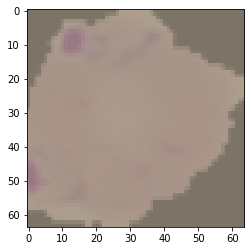

In [136]:
predictions_2(15)

Label: Uninfected (1)
Prediction : Uninfected


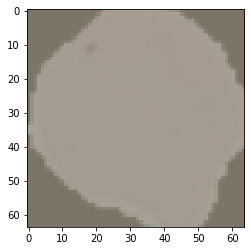

In [137]:
predictions_2(51)

Label: Parasitized (0)
Prediction : Uninfected


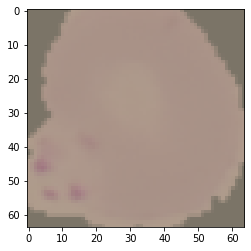

In [138]:
predictions_2(299)